In [1]:
## Here the marking of the grooming bout is only at the start of it, and without the duration of the event.

In [2]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

In [3]:
# --- Add your entities path ---
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import Experiment  # assumes Experiment is defined there

# --- Constants ---
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30  # Hz
PRE_TIME = 5     # seconds before event
POST_TIME = 5    # seconds after event
def load_experiments(data_folder):
    """Load all .pkl experiment files from folder."""
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

In [4]:
def get_sapap_genotype(geno_str):
    """Extract WT/KO from genotype string."""
    if "Sapap(" in geno_str:
        start = geno_str.find("Sapap(") + len("Sapap(")
        end = geno_str.find(")", start)
        return geno_str[start:end]
    return None

def group_experiments_by_genotype(experiments):
    WT, KO = [], []
    for exp in experiments:
        geno = get_sapap_genotype(exp.Genotype)
        if geno == 'WT':
            WT.append(exp)
        elif geno == 'KO':
            KO.append(exp)
        else:
            print(f"Warning: unknown genotype for {exp.Mouse_id}")
    print(f"WT mice: {len(WT)}, KO mice: {len(KO)}")
    return WT, KO

def detect_hd_events(exps):
    """Get start frames of all grooming events (formerly head-dipping)."""
    events = {}
    total = 0
    for exp in exps:
        # Now using Grooming_annotations
        ann = getattr(exp, "Grooming_annotations", None) or []
        starts = [s for s, _ in ann]  # only onset
        events[exp.Mouse_id] = starts
        total += len(starts)
    print(f"Detected {total} grooming events across {len(exps)} mice.")
    return events

def extract_hd_traces(experiments, pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    """
    Fixed-length z-score traces aligned to grooming onset (formerly head-dipping):
    window = [onset - pre_sec, onset + post_sec].
    """
    aligned = {}
    for exp in experiments:
        aligned[exp.Mouse_id] = []

        # Now using Grooming_annotations
        ann = getattr(exp, "Grooming_annotations", None) or []
        if len(ann) == 0:
            continue

        # Data arrays
        t = np.asarray(exp.GCaMP_data.time)
        z = np.asarray(exp.GCaMP_data.z_score)
        if t.ndim != 1 or len(t) != len(z):
            print(f"⚠️ {exp.Mouse_id}: time/z length mismatch ({len(t)} vs {len(z)}); skipping mouse.")
            continue

        for (start_frame, _end_frame) in ann:
            onset_s = start_frame / float(frame_rate)
            w_start = onset_s - float(pre_sec)
            w_end   = onset_s + float(post_sec)

            # bounds check: ensure full window is inside data range
            if w_start < t[0] or w_end > t[-1]:
                # skip events too close to edges
                continue

            # index range using searchsorted (right-exclusive end)
            i0 = int(np.searchsorted(t, w_start, side="left"))
            i1 = int(np.searchsorted(t, w_end,   side="right"))

            trace = z[i0:i1]
            time_rel = t[i0:i1] - onset_s

            # If sampling is irregular, lengths may vary slightly → resample to a common grid:
            aligned[exp.Mouse_id].append((trace, time_rel))

    return aligned

def align_hd_traces(traces_dict, common_t):
    """Interpolate traces to a common time vector."""
    aligned = {}
    for m, traces in traces_dict.items():
        aligned[m] = []
        for (trace, t) in traces:
            aligned[m].append(np.interp(common_t, t, trace))
    return aligned


def compute_hd_avg_traces(aligned_data):
    """
    aligned_data: dict[mouse_id] -> list of 1D arrays, all same length (common_t)
    Returns:
      mouse_avg: dict[mouse_id] -> {"avg": avg, "sem": sem}
      group_avg: 1D np.ndarray
      group_sem: 1D np.ndarray
    """
    mouse_avg = {}
    all_traces = []

    for mouse, traces in aligned_data.items():
        if len(traces) == 0:
            continue
        # Stack events for this mouse (events x time)
        stacked = np.vstack(traces).astype(float)

        # Column-wise NaN-safe stats per mouse
        avg = np.nanmean(stacked, axis=0)
        # use ddof=1 for SEM if n>1, fallback to ddof=0 if only one event
        dd = 1 if stacked.shape[0] > 1 else 0
        sem = np.nanstd(stacked, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(stacked), axis=0).clip(min=1))

        mouse_avg[mouse] = {"avg": avg, "sem": sem}
        all_traces.append(avg)

        print(f"{mouse}: {len(traces)} grooming events used; NaN columns={np.isnan(avg).sum()}")

    if len(all_traces) == 0:
        return mouse_avg, None, None

    all_traces = np.vstack(all_traces).astype(float)  # (mice x time)

    group_avg = np.nanmean(all_traces, axis=0)
    # ddof handling for mice count
    dd = 1 if all_traces.shape[0] > 1 else 0
    group_sem = np.nanstd(all_traces, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(all_traces), axis=0).clip(min=1))

    # Replace any remaining NaNs (e.g., if all mice NaN at some t) with 0 so plotting is stable
    group_avg = np.nan_to_num(group_avg, copy=False)
    group_sem = np.nan_to_num(group_sem, copy=False)

    return mouse_avg, group_avg, group_sem


def build_common_time(pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    # inclusive left, exclusive right works fine; we just need consistent length
    n = int(round((pre_sec + post_sec) * frame_rate))
    return np.linspace(-pre_sec, post_sec, n, endpoint=False)

def align_hd_traces_to_common(traces_dict, common_t):
    """Interpolate each trace to the common_t grid."""
    aligned = {}
    for mouse, traces in traces_dict.items():
        aligned[mouse] = []
        for (y, t_rel) in traces:
            # robust to tiny monotonicity issues
            idx = np.argsort(t_rel)
            t_sorted = t_rel[idx]
            y_sorted = y[idx]
            aligned[mouse].append(np.interp(common_t, t_sorted, y_sorted))
    return aligned

In [5]:
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color):
    if group_avg is None or len(group_avg) == 0:
        print(f"⚠️ Skipping plot for {title} — no valid events found.")
        return

    ok = np.isfinite(common_t) & np.isfinite(group_avg) & np.isfinite(group_sem)
    if not ok.any():
        print(f"⚠️ No finite points to plot for {title}.")
        return

    t = common_t[ok]
    mu = group_avg[ok]
    se = np.abs(group_sem[ok])  # ensure non-negative

    plt.figure(figsize=(8, 5))
    # individual mice
    for m, d in mouse_data.items():
        if "avg" in d and np.isfinite(d["avg"]).any():
            plt.plot(t, np.interp(t, common_t[:len(d["avg"])], d["avg"]), color='gray', alpha=0.5)

    plt.plot(t, mu, color=color, linewidth=2, label=title)
    plt.fill_between(t, mu - se, mu + se, where=np.isfinite(mu - se) & np.isfinite(mu + se),
                     color=color, alpha=0.3)

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to grooming onset)")
    plt.ylabel("Z-scored dF/F")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_combined_WT_KO(common_t,
                        mouse_WT, gavg_WT, gsem_WT,
                        mouse_KO, gavg_KO, gsem_KO):
    # --- quick diagnostics ---
    for name, arr in [("common_t", common_t),
                      ("gavg_WT", gavg_WT), ("gsem_WT", gsem_WT),
                      ("gavg_KO", gavg_KO), ("gsem_KO", gsem_KO)]:
        if arr is not None:
            print(f"{name}: shape={np.shape(arr)}, NaNs={np.isnan(arr).sum() if np.ndim(arr) else 0}")

    def _safe_plot_band(t, mu, se, color, label):
        mu = np.asarray(mu, dtype=float)
        se = np.abs(np.asarray(se, dtype=float))           # ensure SEM ≥ 0
        t  = np.asarray(t,  dtype=float)

        # shape + finiteness checks
        if mu.shape != se.shape or mu.shape != t.shape:
            raise ValueError(f"Shape mismatch for {label}: t{t.shape}, mu{mu.shape}, se{se.shape}")

        ok = np.isfinite(t) & np.isfinite(mu) & np.isfinite(se)
        if not ok.any():
            print(f"⚠️ No finite points for {label}; skipping.")
            return

        t, mu, se = t[ok], mu[ok], se[ok]

        plt.plot(t, mu, color=color, linewidth=2, label=label)
        plt.fill_between(t, mu - se, mu + se, color=color, alpha=0.3)

    plt.figure(figsize=(12, 6))

    if gavg_WT is not None and gsem_WT is not None:
        _safe_plot_band(common_t, gavg_WT, gsem_WT,
                        color='blue', label=f"WT group (mice={len(mouse_WT)})")

    if gavg_KO is not None and gsem_KO is not None:
        _safe_plot_band(common_t, gavg_KO, gsem_KO,
                        color='red',  label=f"KO group (mice={len(mouse_KO)})")

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to grooming onset)")
    plt.ylabel("Z-scored dF/F")
    plt.title("WT vs KO Grooming Z-Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

def center_traces_by_window(traces_dict, fraction: float = 1.0):
    """
    Subtract `fraction` of the mean of the entire chosen window from each event trace.
    fraction=1.0  -> subtract 100% (full centering)
    fraction=0.90 -> subtract 90% (leave 10% of the mean)
    fraction=0.95 -> subtract 95%
    """
    if not np.isfinite(fraction):
        raise ValueError("fraction must be a finite number")
    centered = {}
    for mouse, traces in traces_dict.items():
        out = []
        for arr in traces:
            a = np.asarray(arr, dtype=float)
            m = np.nanmean(a)
            if np.isfinite(m):
                a = a - fraction * m
            out.append(a)
        centered[mouse] = out
    return centered


Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 15
WT mice: 7, KO mice: 8
M329: 62 grooming events used; NaN columns=0
M344: 70 grooming events used; NaN columns=0
M354: 97 grooming events used; NaN columns=0
M365: 50 grooming events used; NaN columns=0
M511: 55 grooming events used; NaN columns=0
M546: 56 grooming events used; NaN columns=0
M561: 48 grooming events used; NaN columns=0
M338: 54 grooming events used; NaN columns=0
M352: 75 grooming events used; NaN columns=0
M406: 88 grooming events used; NaN columns=0
M407: 152 grooming events used; Na

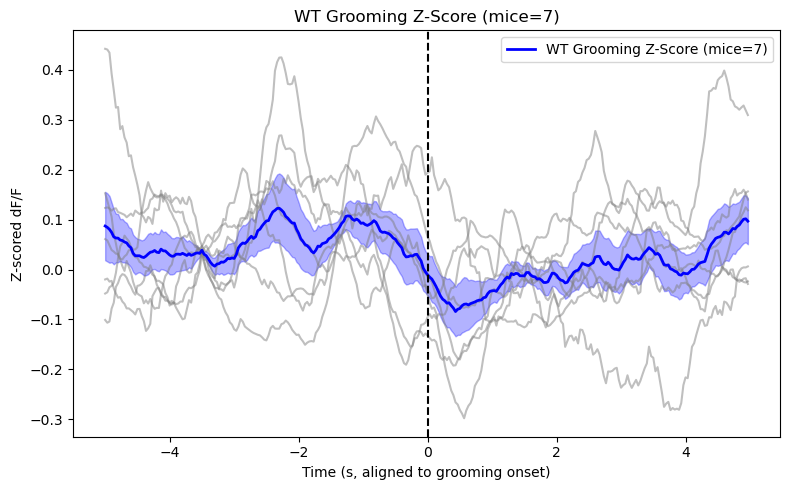

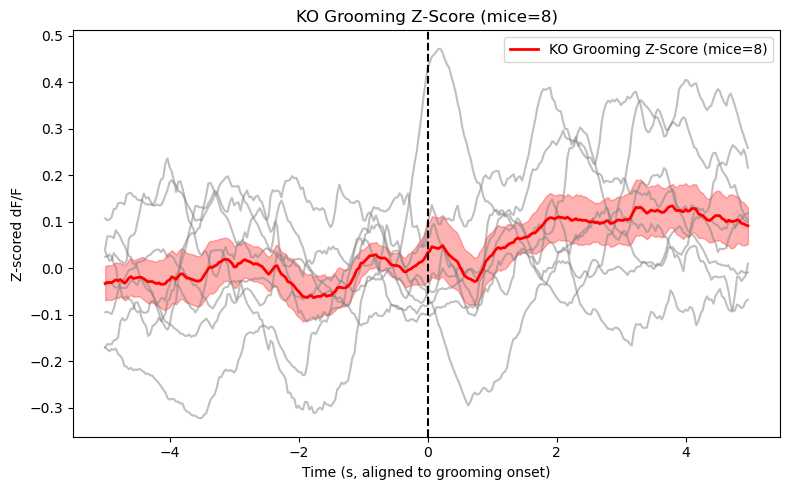

common_t: shape=(300,), NaNs=0
gavg_WT: shape=(300,), NaNs=0
gsem_WT: shape=(300,), NaNs=0
gavg_KO: shape=(300,), NaNs=0
gsem_KO: shape=(300,), NaNs=0


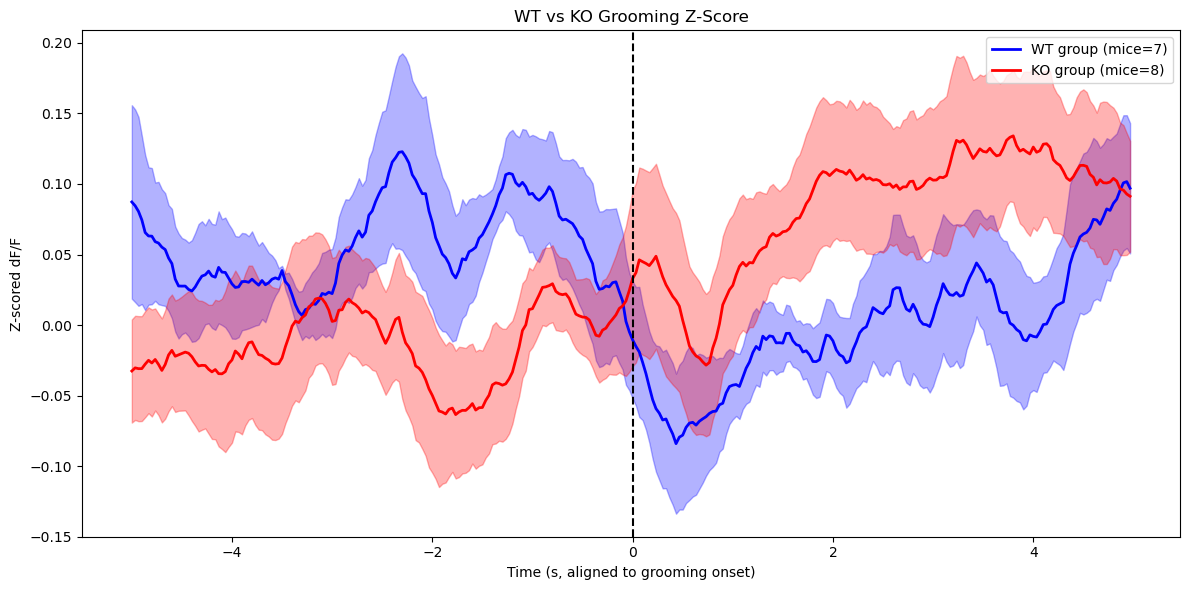

In [6]:
if __name__ == '__main__':
    # 1) Load and split by genotype
    exps = load_experiments(data_folder)
    WT, KO = group_experiments_by_genotype(exps)

    # 2) One canonical common time vector (±PRE/POST at FRAME_RATE)
    common_t = build_common_time(PRE_TIME, POST_TIME, FRAME_RATE)

    # 3) Extract fixed windows around grooming onset (ignore duration)
    raw_WT = extract_hd_traces(WT, pre_sec=PRE_TIME, post_sec=POST_TIME, frame_rate=FRAME_RATE)
    raw_KO = extract_hd_traces(KO, pre_sec=PRE_TIME, post_sec=POST_TIME, frame_rate=FRAME_RATE)

    # 4) Resample each window to the common time grid
    aligned_WT = align_hd_traces_to_common(raw_WT, common_t)
    aligned_KO = align_hd_traces_to_common(raw_KO, common_t)

    BASELINE_REDUCTION = 0.95  # ← use 0.95 to subtract 95%

    # 5) Center each event by subtracting a fraction of its mean over the whole window
    centered_WT = center_traces_by_window(aligned_WT, fraction=BASELINE_REDUCTION)
    centered_KO = center_traces_by_window(aligned_KO, fraction=BASELINE_REDUCTION)

    # 6) Per-mouse and group averages (NaN-safe)
    mouse_WT, gavg_WT, gsem_WT = compute_hd_avg_traces(centered_WT)
    mouse_KO, gavg_KO, gsem_KO = compute_hd_avg_traces(centered_KO)

    # Optional quick diagnostics: mean over time ~ 0 after centering
    if gavg_WT is not None:
        print("WT group mean over window (should be ~0):", float(np.nanmean(gavg_WT)))
    if gavg_KO is not None:
        print("KO group mean over window (should be ~0):", float(np.nanmean(gavg_KO)))

    # 7) Plot per-group
    plot_traces(common_t, mouse_WT, gavg_WT, gsem_WT,
                title=f"WT Grooming Z-Score (mice={len(mouse_WT)})", color="blue")
    plot_traces(common_t, mouse_KO, gavg_KO, gsem_KO,
                title=f"KO Grooming Z-Score (mice={len(mouse_KO)})", color="red")

    # 8) Combined WT vs KO (safe wrapper validates SEM around mean)
    if gavg_WT is not None and gavg_KO is not None:
        plot_combined_WT_KO(common_t,
                            mouse_WT, gavg_WT, gsem_WT,
                            mouse_KO, gavg_KO, gsem_KO)
    else:
        print("⚠️ Skipping combined plot — no valid group average for one or both groups.")


Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 15
Female mice: 9, Male mice: 6
M338: 54 grooming events used; NaN columns=0
M344: 70 grooming events used; NaN columns=0
M354: 97 grooming events used; NaN columns=0
M365: 50 grooming events used; NaN columns=0
M406: 88 grooming events used; NaN columns=0
M407: 152 grooming events used; NaN columns=0
M420: 43 grooming events used; NaN columns=0
M501: 45 grooming events used; NaN columns=0
M508: 77 grooming events used; NaN columns=0
M329: 62 grooming events used; NaN columns=0
M352: 75 grooming events us

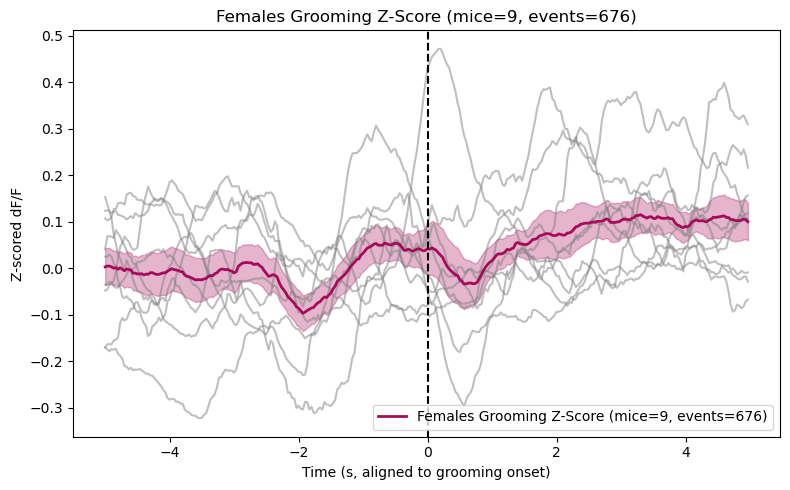

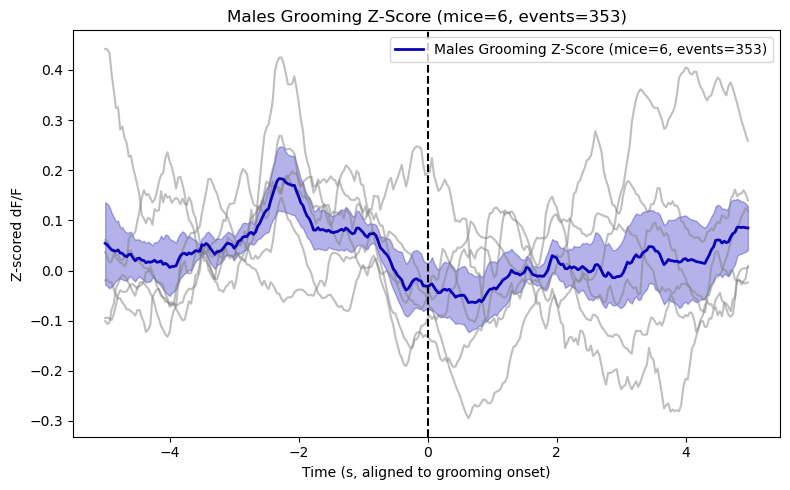

common_t: shape=(300,), NaNs=0
gavg_Females: shape=(300,), NaNs=0
gsem_Females: shape=(300,), NaNs=0
gavg_Males: shape=(300,), NaNs=0
gsem_Males: shape=(300,), NaNs=0


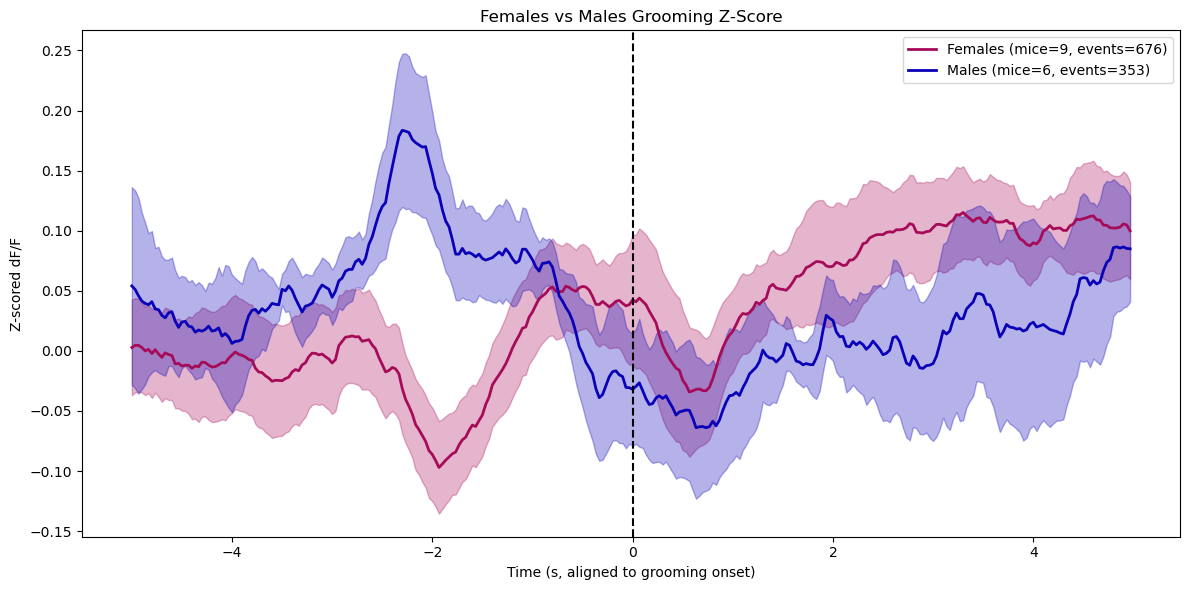

In [7]:
# --- Constants ---
PRE_TIME = 5     # seconds before event
POST_TIME = 5    # seconds after event
BASELINE_REDUCTION = 0.95  # <-- set to 0.90 or 0.95 if you want partial mean subtraction

# ----------------- IO & grouping -----------------
def load_experiments(data_folder):
    """Load all .pkl experiment files from folder."""
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

def _normalize_sex(sex_str):
    if sex_str is None:
        return None
    s = str(sex_str).strip().lower()
    if s in {"f", "female", "♀", "woman", "girl"}:
        return "Female"
    if s in {"m", "male", "♂", "man", "boy"}:
        return "Male"
    return None

def group_experiments_by_sex(experiments):
    females, males = [], []
    for exp in experiments:
        sx = _normalize_sex(getattr(exp, "Sex", None))
        if sx == "Female":
            females.append(exp)
        elif sx == "Male":
            males.append(exp)
        else:
            print(f"Warning: unknown/blank sex for {getattr(exp, 'Mouse_id', 'UNK')}: {getattr(exp, 'Sex', None)}")
    print(f"Female mice: {len(females)}, Male mice: {len(males)}")
    return females, males

# ----------------- Event detection & windows -----------------
def detect_hd_events(exps):
    """Get start frames of all grooming events (formerly head-dipping)."""
    events = {}
    total = 0
    for exp in exps:
        ann = getattr(exp, "Grooming_annotations", None) or []
        starts = [s for s, _ in ann]  # only onset
        events[exp.Mouse_id] = starts
        total += len(starts)
    print(f"Detected {total} grooming events across {len(exps)} mice.")
    return events

def extract_hd_traces(experiments, pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    """
    Fixed-length z-score traces aligned to grooming onset:
    window = [onset - pre_sec, onset + post_sec].
    """
    aligned = {}
    for exp in experiments:
        aligned[exp.Mouse_id] = []

        ann = getattr(exp, "Grooming_annotations", None) or []
        if len(ann) == 0:
            continue

        # Data arrays
        t = np.asarray(exp.GCaMP_data.time)
        z = np.asarray(exp.GCaMP_data.z_score)
        if t.ndim != 1 or len(t) != len(z):
            print(f"⚠️ {exp.Mouse_id}: time/z length mismatch ({len(t)} vs {len(z)}); skipping mouse.")
            continue

        for (start_frame, _end_frame) in ann:
            onset_s = start_frame / float(frame_rate)
            w_start = onset_s - float(pre_sec)
            w_end   = onset_s + float(post_sec)

            # bounds check: ensure full window is inside data range
            if w_start < t[0] or w_end > t[-1]:
                continue  # skip edge events

            # index range using searchsorted (right-exclusive end)
            i0 = int(np.searchsorted(t, w_start, side="left"))
            i1 = int(np.searchsorted(t, w_end,   side="right"))

            trace = z[i0:i1]
            time_rel = t[i0:i1] - onset_s

            aligned[exp.Mouse_id].append((trace, time_rel))

    return aligned

# ----------------- Alignment & averaging -----------------
def build_common_time(pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    # inclusive left, exclusive right works fine; we just need consistent length
    n = int(round((pre_sec + post_sec) * frame_rate))
    return np.linspace(-pre_sec, post_sec, n, endpoint=False)

def align_hd_traces_to_common(traces_dict, common_t):
    """Interpolate each trace to the common_t grid."""
    aligned = {}
    for mouse, traces in traces_dict.items():
        aligned[mouse] = []
        for (y, t_rel) in traces:
            idx = np.argsort(t_rel)
            t_sorted = t_rel[idx]
            y_sorted = y[idx]
            aligned[mouse].append(np.interp(common_t, t_sorted, y_sorted))
    return aligned

def center_traces_by_window(traces_dict, fraction: float = 1.0):
    """
    Subtract `fraction` of the mean of the entire chosen window from each event trace.
    fraction=1.0  -> subtract 100% (full centering)
    fraction=0.90 -> subtract 90% (leave 10% of the mean)
    """
    if not np.isfinite(fraction):
        raise ValueError("fraction must be a finite number")
    centered = {}
    for mouse, traces in traces_dict.items():
        out = []
        for arr in traces:
            a = np.asarray(arr, dtype=float)
            m = np.nanmean(a)
            if np.isfinite(m):
                a = a - fraction * m
            out.append(a)
        centered[mouse] = out
    return centered

def compute_hd_avg_traces(aligned_data):
    """
    aligned_data: dict[mouse_id] -> list of 1D arrays, all same length (common_t)
    Returns:
      mouse_avg: dict[mouse_id] -> {"avg": avg, "sem": sem}
      group_avg: 1D np.ndarray
      group_sem: 1D np.ndarray
    """
    mouse_avg = {}
    all_traces = []

    for mouse, traces in aligned_data.items():
        if len(traces) == 0:
            continue
        stacked = np.vstack(traces).astype(float)  # events x time

        avg = np.nanmean(stacked, axis=0)
        dd = 1 if stacked.shape[0] > 1 else 0
        sem = np.nanstd(stacked, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(stacked), axis=0).clip(min=1))

        mouse_avg[mouse] = {"avg": avg, "sem": sem}
        all_traces.append(avg)

        print(f"{mouse}: {len(traces)} grooming events used; NaN columns={np.isnan(avg).sum()}")

    if len(all_traces) == 0:
        return mouse_avg, None, None

    all_traces = np.vstack(all_traces).astype(float)  # mice x time
    group_avg = np.nanmean(all_traces, axis=0)
    dd = 1 if all_traces.shape[0] > 1 else 0
    group_sem = np.nanstd(all_traces, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(all_traces), axis=0).clip(min=1))

    group_avg = np.nan_to_num(group_avg, copy=False)
    group_sem = np.nan_to_num(group_sem, copy=False)

    return mouse_avg, group_avg, group_sem

def count_group_events(traces_dict):
    """Total number of grooming events in a group after alignment/centering."""
    return int(sum(len(v) for v in traces_dict.values()))

# ----------------- Plotting -----------------
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color):
    if group_avg is None or len(group_avg) == 0:
        print(f"⚠️ Skipping plot for {title} — no valid events found.")
        return

    ok = np.isfinite(common_t) & np.isfinite(group_avg) & np.isfinite(group_sem)
    if not ok.any():
        print(f"⚠️ No finite points to plot for {title}.")
        return

    t = common_t[ok]
    mu = group_avg[ok]
    se = np.abs(group_sem[ok])

    plt.figure(figsize=(8, 5))
    # individual mice
    for m, d in mouse_data.items():
        if "avg" in d and np.isfinite(d["avg"]).any():
            plt.plot(t, np.interp(t, common_t[:len(d["avg"])], d["avg"]), color='gray', alpha=0.5)

    plt.plot(t, mu, color=color, linewidth=2, label=title)
    plt.fill_between(t, mu - se, mu + se, where=np.isfinite(mu - se) & np.isfinite(mu + se),
                     color=color, alpha=0.3)

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to grooming onset)")
    plt.ylabel("Z-scored dF/F")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_combined_groups(common_t,
                         mouse_A, gavg_A, gsem_A, name_A, events_A,
                         mouse_B, gavg_B, gsem_B, name_B, events_B):
    # --- quick diagnostics ---
    for name, arr in [("common_t", common_t),
                      (f"gavg_{name_A}", gavg_A), (f"gsem_{name_A}", gsem_A),
                      (f"gavg_{name_B}", gavg_B), (f"gsem_{name_B}", gsem_B)]:
        if arr is not None:
            print(f"{name}: shape={np.shape(arr)}, NaNs={np.isnan(arr).sum() if np.ndim(arr) else 0}")

    def _safe_plot_band(t, mu, se, color, label):
        mu = np.asarray(mu, dtype=float)
        se = np.abs(np.asarray(se, dtype=float))
        t  = np.asarray(t,  dtype=float)
        if mu.shape != se.shape or mu.shape != t.shape:
            raise ValueError(f"Shape mismatch for {label}: t{t.shape}, mu{mu.shape}, se{se.shape}")
        ok = np.isfinite(t) & np.isfinite(mu) & np.isfinite(se)
        if not ok.any():
            print(f"⚠️ No finite points for {label}; skipping.")
            return
        t, mu, se = t[ok], mu[ok], se[ok]
        plt.plot(t, mu, color=color, linewidth=2, label=label)
        plt.fill_between(t, mu - se, mu + se, color=color, alpha=0.3)

    plt.figure(figsize=(12, 6))

    if gavg_A is not None and gsem_A is not None:
        label_A = f"{name_A} (mice={len(mouse_A)}, events={events_A})"
        _safe_plot_band(common_t, gavg_A, gsem_A, color='#A60B59', label=label_A)

    if gavg_B is not None and gsem_B is not None:
        label_B = f"{name_B} (mice={len(mouse_B)}, events={events_B})"
        _safe_plot_band(common_t, gavg_B, gsem_B, color='#0900B7', label=label_B)

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to grooming onset)")
    plt.ylabel("Z-scored dF/F")
    plt.title(f"{name_A} vs {name_B} Grooming Z-Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------- Main -----------------
if __name__ == '__main__':
    # 1) Load and split by sex
    exps = load_experiments(data_folder)
    Females, Males = group_experiments_by_sex(exps)

    # 2) One canonical common time vector (±PRE/POST at FRAME_RATE)
    common_t = build_common_time(PRE_TIME, POST_TIME, FRAME_RATE)

    # 3) Extract fixed windows around grooming onset (ignore duration)
    raw_F = extract_hd_traces(Females, pre_sec=PRE_TIME, post_sec=POST_TIME, frame_rate=FRAME_RATE)
    raw_M = extract_hd_traces(Males,   pre_sec=PRE_TIME, post_sec=POST_TIME, frame_rate=FRAME_RATE)

    # 4) Resample each window to the common time grid
    aligned_F = align_hd_traces_to_common(raw_F, common_t)
    aligned_M = align_hd_traces_to_common(raw_M, common_t)

    # 5) Optional: subtract a fraction of each event's window mean
    centered_F = center_traces_by_window(aligned_F, fraction=BASELINE_REDUCTION)
    centered_M = center_traces_by_window(aligned_M, fraction=BASELINE_REDUCTION)

    # 6) Per-mouse and group averages (NaN-safe)
    mouse_F, gavg_F, gsem_F = compute_hd_avg_traces(centered_F)
    mouse_M, gavg_M, gsem_M = compute_hd_avg_traces(centered_M)

    # Event counts (reflect what was actually averaged)
    n_events_F = count_group_events(centered_F)
    n_events_M = count_group_events(centered_M)

    # Diagnostics
    print(f"Females mice used: {len(mouse_F)} | events: {n_events_F}")
    print(f"Males   mice used: {len(mouse_M)} | events: {n_events_M}")

    # 7) Plot per-group
    plot_traces(common_t, mouse_F, gavg_F, gsem_F,
                title=f"Females Grooming Z-Score (mice={len(mouse_F)}, events={n_events_F})", color="#A60B59")
    plot_traces(common_t, mouse_M, gavg_M, gsem_M,
                title=f"Males Grooming Z-Score (mice={len(mouse_M)}, events={n_events_M})", color="#0900B7")

    # 8) Combined plot (Females vs Males)
    if gavg_F is not None and gavg_M is not None:
        plot_combined_groups(common_t,
                             mouse_F, gavg_F, gsem_F, "Females", n_events_F,
                             mouse_M, gavg_M, gsem_M, "Males",   n_events_M)
    else:
        print("⚠️ Skipping combined plot — no valid group average for one or both groups.")

add statistical tests